In [660]:
from os import path
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

import numpy as np

from scipy import stats

from datetime import datetime, timezone
from dateutil import tz
import pytz

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

In [661]:
res = pd.read_csv("alameda-county-2018-amy-aggregate-restock.csv")
# res["Timestamp (PST)"] = pd.DatetimeIndex(res['Timestamp (EST)']).tz_convert("America/Los_Angeles")
res.insert(0, "date", pd.DatetimeIndex(res['Timestamp (EST)']).tz_convert("America/Los_Angeles"))
res.insert(1, "year", [t.year for t in res["date"]])
# res.insert(2, "month", [t.month for t in res["date"]])
# res.insert(3, "day", [t.day for t in res["date"]])
# res.insert(4, "hour", [t.hour for t in res["date"]])
# res.insert(1, "date", [t.date for t in res["Timestamp (PST)"]])
res = res.drop(columns="Timestamp (EST)")
res = res[res["year"] == 2018]
res

,date,year,baseline.out.electricity.ceiling_fan.energy_consumption.kwh,baseline.out.electricity.clothes_dryer.energy_consumption.kwh,baseline.out.electricity.clothes_washer.energy_consumption.kwh,baseline.out.electricity.cooling_fans_pumps.energy_consumption.kwh,baseline.out.electricity.cooling.energy_consumption.kwh,baseline.out.electricity.dishwasher.energy_consumption.kwh,baseline.out.electricity.freezer.energy_consumption.kwh,baseline.out.electricity.heating_fans_pumps.energy_consumption.kwh,...,baseline.out.propane.heating_hp_bkup.energy_consumption.kwh,baseline.out.propane.heating.energy_consumption.kwh,baseline.out.propane.hot_water.energy_consumption.kwh,baseline.out.propane.range_oven.energy_consumption.kwh,baseline.out.site_energy.total.energy_consumption.kwh,baseline.out.electricity.total.energy_consumption.kwh,baseline.out.fuel_oil.total.energy_consumption.kwh,baseline.out.natural_gas.total.energy_consumption.kwh,baseline.out.propane.total.energy_consumption.kwh,baseline.upgrade.kwh
11,2018-01-01 00:00:00-08:00,2018,697.337317,2752.061091,279.903451,47.941941,1230.994069,330.266701,544.068386,3339.955190,...,0.0,2032.978735,1140.281870,0.000000,340675.050760,92691.141506,0.0,244752.430899,3231.307189,0
12,2018-01-01 00:15:00-08:00,2018,589.346885,3522.521973,250.605598,50.847513,284.746071,410.412067,544.068386,1539.226848,...,0.0,983.243860,99.488156,0.000000,176963.741715,70483.369281,0.0,105407.062799,1082.732016,0
13,2018-01-01 00:30:00-08:00,2018,578.935251,3199.034940,321.549985,44.067844,229.298069,318.644413,544.068386,1650.849245,...,0.0,1099.904722,65.781399,0.000000,193269.864702,72527.197159,0.0,119581.925243,1165.686121,0
14,2018-01-01 00:45:00-08:00,2018,563.196736,2873.126597,314.770317,40.435879,222.034139,334.140798,544.068386,1757.629021,...,0.0,1205.566537,475.158840,0.000000,200024.627967,71186.759873,0.0,127097.112960,1746.293891,0
15,2018-01-01 01:00:00-08:00,2018,555.690674,2928.090337,205.084968,35.835390,1254.480777,267.796900,544.068386,1860.050440,...,0.0,1292.778337,423.924568,0.000000,207388.880371,72163.032116,0.0,133390.980665,1839.892235,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 20:00:00-08:00,2018,1654.965472,7712.114886,616.949820,86.682903,459.080400,2372.883925,699.516496,1540.921765,...,0.0,1114.309926,2286.098744,176.126679,367859.302411,155724.865918,0.0,208559.108034,3576.535349,0
35036,2018-12-31 20:15:00-08:00,2018,1698.549054,6740.443132,638.257350,102.421418,497.337100,2203.150085,699.516496,1604.117959,...,0.0,1124.244549,1807.604709,176.126679,349968.819893,140017.100730,0.0,206849.430326,3107.975937,0
35037,2018-12-31 20:30:00-08:00,2018,1703.391675,6364.655801,598.547863,85.956510,441.162705,2030.510673,699.516496,1658.597437,...,0.0,1229.054825,1667.739405,82.244489,348508.501230,141611.533449,0.0,203922.122610,2979.038719,0
35038,2018-12-31 20:45:00-08:00,2018,1688.621683,5909.207366,441.889098,87.651427,442.131229,1739.469195,699.516496,1744.311816,...,0.0,1311.512198,1190.380756,0.000000,360949.842870,140597.730898,0.0,217861.179673,2501.892954,0


In [662]:
res_electricity = res[[col for col in res.columns if "baseline.out.electricity" in col]]
res_electricity = res_electricity.rename(columns=dict(zip(res_electricity.columns, [c[25:-23] for c in res_electricity.columns])))
res_electricity["date"] = res["date"]

In [663]:
all_data = pd.read_csv("wattime_data.csv")
df = all_data
df["date"] = [datetime.fromisoformat(s[:-1]) for s in df["point_time"]]
df["date"] = [timestamp.tz_localize("America/Los_Angeles", ambiguous=0, nonexistent="shift_forward") for timestamp in df["date"]]
df["time"] = pd.DatetimeIndex(df['date']).time
df["year"] = [d.year for d in df["date"]]
df["month"] = [d.month for d in df["date"]]
df["day_of_month"] = pd.DatetimeIndex(df['date']).day
df["day_of_week"] = [datetime.weekday(d) for d in df["date"]]
df["day_of_week"] = df["day_of_week"].replace({0 : "Mon", 1 : "Tue", 2 : "Wed", 3 : "Thurs", 4 : "Fri", 5 : "Sat", 6 : "Sun"})
df["hour"] = [d.hour for d in df["time"]]
df["minute"] = [d.minute for d in df["time"]]
df = df.rename(columns = {"value" : "MOER"})
df = df.drop("point_time", axis=1)
data18 = df[df['year'] == 2018]
data18 = data18.sort_values("date")
data18 = data18[data18["minute"] % 15 == 0]
data18 = data18.drop(["frequency", "market", "ba", "datatype", "version"], axis= 1)
data18 = data18.drop_duplicates()
data18

,Unnamed: 0,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute
0,96,1022.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0
3,93,1021.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15
6,90,1018.0,2018-01-01 00:30:00-08:00,00:30:00,2018,1,1,Mon,0,30
9,87,1006.0,2018-01-01 00:45:00-08:00,00:45:00,2018,1,1,Mon,0,45
12,84,1007.0,2018-01-01 01:00:00-08:00,01:00:00,2018,1,1,Mon,1,0
...,...,...,...,...,...,...,...,...,...,...
105117,111,982.0,2018-12-31 22:45:00-08:00,22:45:00,2018,12,31,Mon,22,45
105120,108,1025.0,2018-12-31 23:00:00-08:00,23:00:00,2018,12,31,Mon,23,0
105123,105,1017.0,2018-12-31 23:15:00-08:00,23:15:00,2018,12,31,Mon,23,15
105126,102,1028.0,2018-12-31 23:30:00-08:00,23:30:00,2018,12,31,Mon,23,30


In [665]:
all18 = data18.merge(res_electricity, on= "date")
all18 = all18.drop(['Unnamed: 0'], axis= 1)
# all18 = all18.sort_values(by=['MOER'], ascending= False)
all18

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
0,1022.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0,697.337317,...,205.811361,5519.376435,290.799346,35332.483770,4.600489,313.075399,621.792441,8153.519723,1421.066914,92691.141506
1,1021.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15,589.346885,...,178.692687,3875.306859,217.917911,34428.608700,4.600489,313.075399,552.300840,8096.376804,961.502252,70483.369281
2,1018.0,2018-01-01 00:30:00-08:00,00:30:00,2018,1,1,Mon,0,30,578.935251,...,178.692687,3843.345565,217.917911,34297.373691,4.600489,313.075399,470.218427,8096.376804,961.502252,72527.197159
3,1006.0,2018-01-01 00:45:00-08:00,00:45:00,2018,1,1,Mon,0,45,563.196736,...,178.692687,3747.703815,217.917911,34041.199079,4.600489,313.075399,288.862298,8096.376804,961.502252,71186.759873
4,1007.0,2018-01-01 01:00:00-08:00,01:00:00,2018,1,1,Mon,1,0,555.690674,...,178.692687,3724.217107,217.917911,33964.443548,4.600489,313.075399,196.368251,8096.376804,961.502252,72163.032116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35044,984.0,2018-12-31 20:00:00-08:00,20:00:00,2018,12,31,Mon,20,0,1654.965472,...,260.048708,44433.704277,468.765641,56089.649098,12.348682,851.816903,3204.361822,9681.850675,1662.471533,155724.865918
35045,968.0,2018-12-31 20:15:00-08:00,20:15:00,2018,12,31,Mon,20,15,1698.549054,...,301.695242,36532.485069,415.254687,53318.701789,5.811144,418.644521,2690.559813,9587.903842,1769.251310,140017.100730
35046,961.0,2018-12-31 20:30:00-08:00,20:30:00,2018,12,31,Mon,20,30,1703.391675,...,301.695242,36826.189988,415.254687,53556.474443,5.811144,418.644521,2224.699745,9587.903842,1769.251310,141611.533449
35047,960.0,2018-12-31 20:45:00-08:00,20:45:00,2018,12,31,Mon,20,45,1688.621683,...,301.695242,36507.545575,415.254687,53342.672759,5.811144,418.644521,2183.779604,9587.903842,1769.251310,140597.730898


In [666]:
def get_extreme_peaks_by_percentile(percentile, waking_hours_only=False, value = "MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified percentile of all MOER data
    
    percentile - int in [0, 100] that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = all18[~all18["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = all18
    
    data = data.reset_index(drop=True)
    
    moers = data[value]

    cutoff = np.percentile(moers, percentile)
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
    
    return data.iloc[peak_indices]

In [667]:
def get_extreme_peaks_by_value(cutoff, waking_hours_only=False, value = "MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    cutoff - MOER cutoff that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = all18[~all18["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = all18
    
    data = data.reset_index(drop=True)
    
    moers = data[value]
    
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [668]:
def get_top_n_peaks(n, waking_hours_only=False, value = "MOER"):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    n - number of peaks to return
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    return get_extreme_peaks_by_percentile(99, waking_hours_only).sort_values(by=[value], ascending=False).head(n)

In [669]:
df = all18
top_100_peaks = get_top_n_peaks(100, waking_hours_only=True)

<AxesSubplot:xlabel='date', ylabel='MOER'>

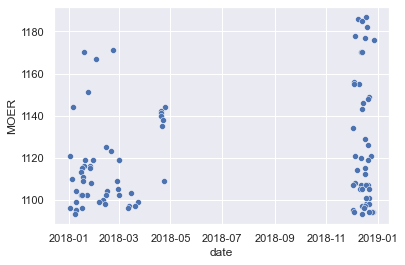

In [670]:
sns.scatterplot(data=top_100_peaks, x="date", y="MOER")

<AxesSubplot:xlabel='hour', ylabel='MOER'>

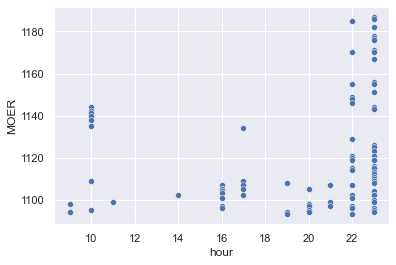

In [671]:
sns.scatterplot(data=top_100_peaks, x="hour", y="MOER")

In [672]:
all18.columns

Index(['MOER', 'date', 'time', 'year', 'month', 'day_of_month', 'day_of_week',
       'hour', 'minute', 'ceiling_fan', 'clothes_dryer', 'clothes_washer',
       'cooling_fans_pumps', 'cooling', 'dishwasher', 'freezer',
       'heating_fans_pumps', 'heating_hp_bkup', 'heating', 'hot_tub_heater',
       'hot_tub_pump', 'hot_water', 'lighting_exterior', 'lighting_garage',
       'lighting_interior', 'mech_vent', 'plug_loads', 'pool_heater',
       'pool_pump', 'range_oven', 'refrigerator', 'well_pump', 'total'],
      dtype='object')

In [673]:
def get_pie(timestamp):
    df = all18.loc[all18["date"] == timestamp]
    print("Timestamp: " + timestamp)
    print("MOER: " + str(df["MOER"]))
    df = df.drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])
    to_plot = pd.DataFrame({"MOER": df.values[0], "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:3], "Appliance" : df.columns})
    to_plot = to_plot.sort_values(by="MOER")
    plt.pie(to_plot["MOER"], labels = to_plot["Appliance"], colors = to_plot["color"], autopct='%.0f%%')

In [674]:
sns.set(rc={'figure.figsize':(20,8.27)})
all18[all18["date"] == "2018-02-04 16:00:00-08:00"]

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
3330,75.0,2018-02-04 16:00:00-08:00,16:00:00,2018,2,4,Sun,16,0,773.850717,...,123.002554,17117.209814,274.334437,48427.17107,93.704702,6431.726091,2590.801836,8149.161364,727.603693,122906.912715


In [675]:
top_100_peaks.sort_values("MOER", ascending=False)

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
22473,1187.0,2018-12-17 23:15:00-08:00,23:15:00,2018,12,17,Mon,23,15,825.424622,...,205.811361,6853.276184,290.799346,36906.577484,4.600489,313.075399,613.075724,8153.519723,1421.066914,83480.719913
21833,1186.0,2018-12-07 23:15:00-08:00,23:15:00,2018,12,7,Fri,23,15,843.584448,...,205.811361,7010.177080,290.799346,37069.531656,4.600489,313.075399,1120.824458,8153.519723,1421.066914,83939.316051
22149,1185.0,2018-12-12 22:15:00-08:00,22:15:00,2018,12,12,Wed,22,15,1186.199831,...,232.930034,18345.540441,306.537862,42983.339510,4.600489,313.075399,1148.669524,8876.522927,1640.195480,105826.022554
22539,1182.0,2018-12-18 23:45:00-08:00,23:45:00,2018,12,18,Tue,23,45,718.160584,...,205.811361,5805.575292,290.799346,35588.658382,4.600489,313.075399,351.816361,8153.519723,1421.066914,74081.920392
21641,1178.0,2018-12-04 23:15:00-08:00,23:15:00,2018,12,4,Tue,23,15,823.971836,...,205.811361,6804.123589,290.799346,36913.357152,4.600489,313.075399,349.637182,8153.519723,1421.066914,89421.888572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22866,1094.0,2018-12-24 09:30:00-08:00,09:30:00,2018,12,24,Mon,9,30,689.346993,...,54.237347,14933.672341,303.148028,42913.847910,184.988094,12689.602115,2466.830758,8153.519723,699.032234,122323.861237
22864,1094.0,2018-12-24 09:00:00-08:00,09:00:00,2018,12,24,Mon,9,0,757.627939,...,123.002554,14335.850871,284.261809,42715.542610,128.087306,8798.556740,3386.686475,8153.519723,718.402715,121984.635688
22652,1094.0,2018-12-20 20:00:00-08:00,20:00:00,2018,12,20,Thurs,20,0,1639.226956,...,260.048708,43665.664704,468.765641,55877.058069,12.348682,851.816903,3456.420207,9681.850675,1662.471533,154128.738283
22138,1093.0,2018-12-12 19:30:00-08:00,19:30:00,2018,12,12,Wed,19,30,1579.178465,...,260.048708,41700.045143,468.765641,54889.163537,12.348682,851.816903,4867.317618,9681.850675,1662.471533,144068.678966


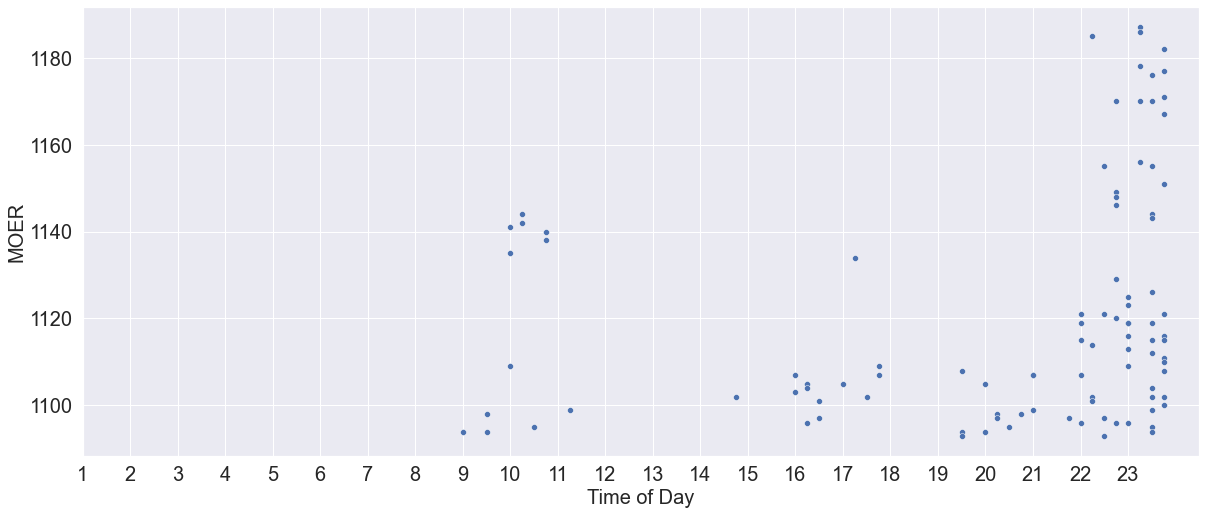

In [676]:
top_100_peaks_hour = [t.hour + t.minute/60 for t in top_100_peaks["time"]]
sns.scatterplot(x=top_100_peaks_hour, y=top_100_peaks["MOER"])
plt.xticks(range(1, 24, 1), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time of Day", fontsize=20)
plt.ylabel("MOER", fontsize=20)
plt.show()

## Average energy consumption during a top 100 peak

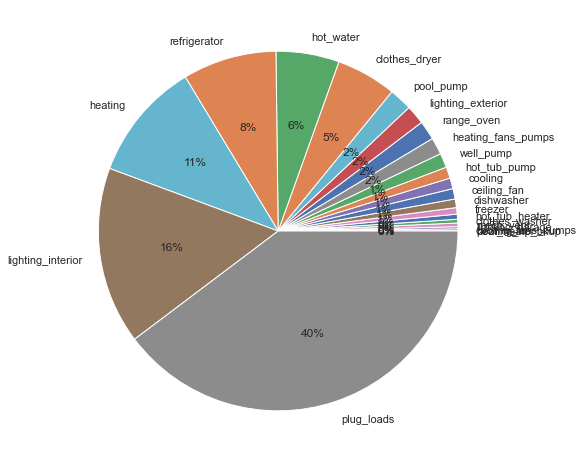

In [718]:
means = top_100_peaks.mean().drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])[6:-1]
to_plot = pd.DataFrame({"Appliance": means.index, "Value": means, "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:3]})
to_plot = to_plot.sort_values(by="Value")
plt.pie(to_plot["Value"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%');

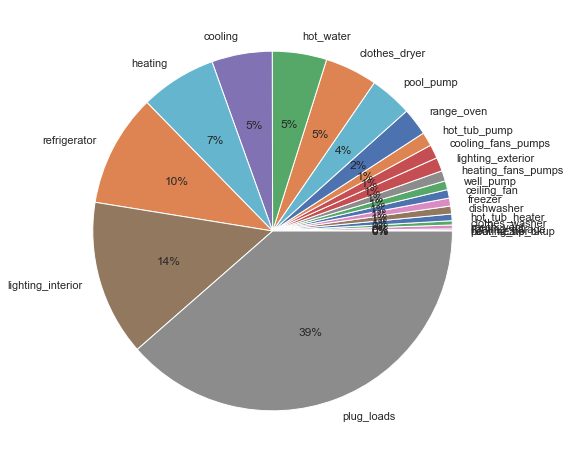

In [719]:
all_means = all18.mean().drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])[6:-1]
to_plot = pd.DataFrame({"Appliance": all_means.index, "Value": all_means, "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:3]})
to_plot = to_plot.sort_values(by="Value")
plt.pie(to_plot["Value"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%');

In [720]:
means = means.sort_values(ascending=False)

In [721]:
df1 = pd.DataFrame({"kWH" : means})
df2 = pd.DataFrame({"kWH" : all_means})

In [722]:
combined = pd.merge(df1, df2, left_index=True, right_index=True).rename(columns={"kWH_x" : "2018 Top 100 Peak Average Load Profile", "kWH_y" : "2018 Average Load Profile"})
combined["Use"] = combined.index
combined = combined.melt(id_vars=["Use"])

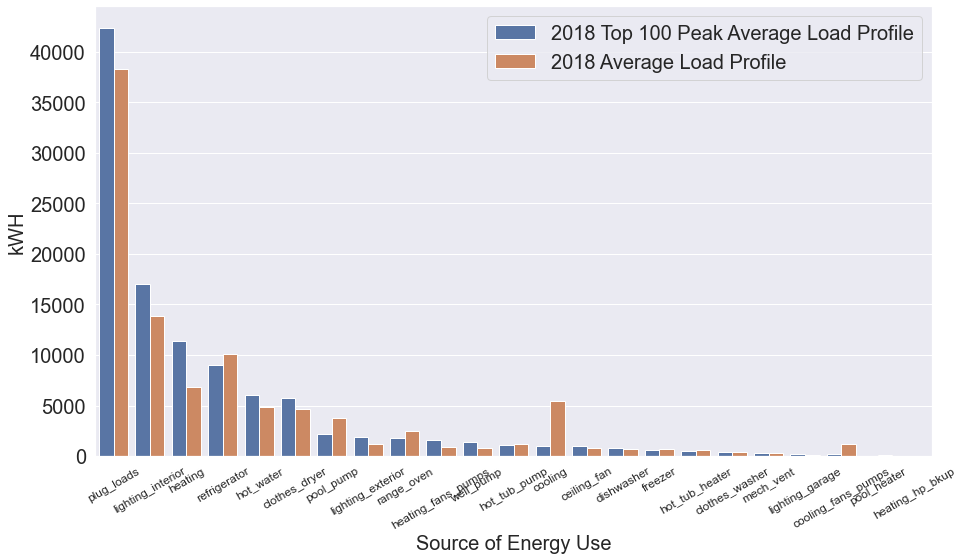

In [723]:
sns.barplot(data=combined, x="Use", y="value", hue="variable")
plt.xlabel("Source of Energy Use", fontsize=20)
plt.ylabel("kWH", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=30, fontsize=12)
plt.legend(loc=1, prop={'size': 20});

In [726]:
sum(df1["kWH"])

106669.32855127174

In [727]:
sum(df2["kWH"])

99325.24552525248

In [728]:
df

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
0,1022.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0,697.337317,...,205.811361,5519.376435,290.799346,35332.483770,4.600489,313.075399,621.792441,8153.519723,1421.066914,92691.141506
1,1021.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15,589.346885,...,178.692687,3875.306859,217.917911,34428.608700,4.600489,313.075399,552.300840,8096.376804,961.502252,70483.369281
2,1018.0,2018-01-01 00:30:00-08:00,00:30:00,2018,1,1,Mon,0,30,578.935251,...,178.692687,3843.345565,217.917911,34297.373691,4.600489,313.075399,470.218427,8096.376804,961.502252,72527.197159
3,1006.0,2018-01-01 00:45:00-08:00,00:45:00,2018,1,1,Mon,0,45,563.196736,...,178.692687,3747.703815,217.917911,34041.199079,4.600489,313.075399,288.862298,8096.376804,961.502252,71186.759873
4,1007.0,2018-01-01 01:00:00-08:00,01:00:00,2018,1,1,Mon,1,0,555.690674,...,178.692687,3724.217107,217.917911,33964.443548,4.600489,313.075399,196.368251,8096.376804,961.502252,72163.032116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35044,984.0,2018-12-31 20:00:00-08:00,20:00:00,2018,12,31,Mon,20,0,1654.965472,...,260.048708,44433.704277,468.765641,56089.649098,12.348682,851.816903,3204.361822,9681.850675,1662.471533,155724.865918
35045,968.0,2018-12-31 20:15:00-08:00,20:15:00,2018,12,31,Mon,20,15,1698.549054,...,301.695242,36532.485069,415.254687,53318.701789,5.811144,418.644521,2690.559813,9587.903842,1769.251310,140017.100730
35046,961.0,2018-12-31 20:30:00-08:00,20:30:00,2018,12,31,Mon,20,30,1703.391675,...,301.695242,36826.189988,415.254687,53556.474443,5.811144,418.644521,2224.699745,9587.903842,1769.251310,141611.533449
35047,960.0,2018-12-31 20:45:00-08:00,20:45:00,2018,12,31,Mon,20,45,1688.621683,...,301.695242,36507.545575,415.254687,53342.672759,5.811144,418.644521,2183.779604,9587.903842,1769.251310,140597.730898


In [729]:
stats.pearsonr(df["MOER"], df["total"])

(-0.23430446027140753, 0.0)

In [730]:
categories =  ['ceiling_fan', 'clothes_dryer', 'clothes_washer',
       'cooling_fans_pumps', 'cooling', 'dishwasher', 'freezer',
       'heating_fans_pumps', 'heating_hp_bkup', 'heating', 'hot_tub_heater',
       'hot_tub_pump', 'hot_water', 'lighting_exterior', 'lighting_garage',
       'lighting_interior', 'mech_vent', 'plug_loads', 'pool_heater',
       'pool_pump', 'range_oven', 'refrigerator', 'well_pump', 'total']

for cat in categories:
    r = stats.pearsonr(df["MOER"], df[cat])[0]
    print(f"Correlation between {cat} and MOER: {r}")
    

Correlation between ceiling_fan and MOER: -0.3935822281765534
Correlation between clothes_dryer and MOER: -0.18585227750288646
Correlation between clothes_washer and MOER: -0.15018255938491482
Correlation between cooling_fans_pumps and MOER: -0.2923347351556274
Correlation between cooling and MOER: -0.2823389232310696
Correlation between dishwasher and MOER: -0.2998938932398505
Correlation between freezer and MOER: -0.43030936039843126
Correlation between heating_fans_pumps and MOER: 0.24858293649208515
Correlation between heating_hp_bkup and MOER: nan
Correlation between heating and MOER: 0.24905596160280122
Correlation between hot_tub_heater and MOER: -0.35009290456311276
Correlation between hot_tub_pump and MOER: -0.3045494220639061
Correlation between hot_water and MOER: -0.2588633004921991
Correlation between lighting_exterior and MOER: -0.3212754631072626
Correlation between lighting_garage and MOER: -0.31741187499545703
Correlation between lighting_interior and MOER: -0.31721233

In [731]:
import statsmodels.api as sm

cross_corrs = sm.tsa.stattools.ccf(df["MOER"], df["total"], adjusted=False)

for i in range(97):
    print(f"{i / 4} hour lag correlation {cross_corrs[i]}")

0.0 hour lag correlation -0.23430446027140756
0.25 hour lag correlation -0.24996204429989888
0.5 hour lag correlation -0.26267544775470064
0.75 hour lag correlation -0.2715284122831663
1.0 hour lag correlation -0.28189282607777216
1.25 hour lag correlation -0.289998897211749
1.5 hour lag correlation -0.2943964319384732
1.75 hour lag correlation -0.2947279476005643
2.0 hour lag correlation -0.2952772355378633
2.25 hour lag correlation -0.29367769256240084
2.5 hour lag correlation -0.2886345716962222
2.75 hour lag correlation -0.2804999935056521
3.0 hour lag correlation -0.27117769062830177
3.25 hour lag correlation -0.2606499659718465
3.5 hour lag correlation -0.2481177227545702
3.75 hour lag correlation -0.23418121468260872
4.0 hour lag correlation -0.2189935502019906
4.25 hour lag correlation -0.20363567391018184
4.5 hour lag correlation -0.18926312722340635
4.75 hour lag correlation -0.1752255023407227
5.0 hour lag correlation -0.16067583403964017
5.25 hour lag correlation -0.1463411

In [732]:
top_100_MOER_peaks = get_top_n_peaks(100, waking_hours_only=True, value = "MOER").sort_values("date")

In [733]:
top_100_MOER_peaks

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
57,1121.0,2018-01-01 22:00:00-08:00,22:00:00,2018,1,1,Mon,22,0,1518.887843,...,260.048708,27362.257224,343.099645,49181.167043,4.600489,313.075399,1355.933671,9219.138310,1876.999611,125246.382560
125,1096.0,2018-01-02 23:00:00-08:00,23:00:00,2018,1,2,Tue,23,0,1020.340088,...,232.930034,15840.210853,306.537862,40289.631994,4.600489,313.075399,718.402715,8876.522927,1640.195480,106380.502573
256,1110.0,2018-01-04 23:45:00-08:00,23:45:00,2018,1,4,Thurs,23,45,729.782872,...,205.811361,5751.337945,290.799346,35821.588416,4.600489,313.075399,604.359008,8153.519723,1421.066914,72634.945460
319,1144.0,2018-01-05 23:30:00-08:00,23:30:00,2018,1,5,Fri,23,30,785.715136,...,205.811361,6587.658463,290.799346,36523.041960,4.600489,313.075399,636.804563,8153.519723,1421.066914,90764.020776
507,1093.0,2018-01-08 22:30:00-08:00,22:30:00,2018,1,8,Mon,22,30,1152.785752,...,232.930034,19411.885421,306.537862,42440.966042,4.600489,313.075399,1251.090943,8876.522927,1640.195480,109048.786333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22859,1121.0,2018-12-23 23:45:00-08:00,23:45:00,2018,12,23,Sun,23,45,781.356778,...,205.811361,6324.946314,290.799346,36348.223369,4.600489,313.075399,222.760532,8153.519723,1421.066914,79584.347656
22864,1094.0,2018-12-24 09:00:00-08:00,09:00:00,2018,12,24,Mon,9,0,757.627939,...,123.002554,14335.850871,284.261809,42715.542610,128.087306,8798.556740,3386.686475,8153.519723,718.402715,121984.635688
22866,1094.0,2018-12-24 09:30:00-08:00,09:30:00,2018,12,24,Mon,9,30,689.346993,...,54.237347,14933.672341,303.148028,42913.847910,184.988094,12689.602115,2466.830758,8153.519723,699.032234,122323.861237
22986,1094.0,2018-12-25 23:30:00-08:00,23:30:00,2018,12,25,Tue,23,30,786.925791,...,205.811361,6434.631663,290.799346,36329.095019,4.600489,313.075399,675.303394,8153.519723,1421.066914,87211.716688


In [734]:
top_100_demand_peaks = get_top_n_peaks(100, waking_hours_only=True, value = "total").sort_values("date")
top_100_demand_peaks

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,ceiling_fan,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
57,1121.0,2018-01-01 22:00:00-08:00,22:00:00,2018,1,1,Mon,22,0,1518.887843,...,260.048708,27362.257224,343.099645,49181.167043,4.600489,313.075399,1355.933671,9219.138310,1876.999611,125246.382560
60,1092.0,2018-01-01 22:45:00-08:00,22:45:00,2018,1,1,Mon,22,45,1032.930900,...,232.930034,16484.763608,306.537862,40745.564691,4.600489,313.075399,700.727151,8876.522927,1640.195480,103953.623432
125,1096.0,2018-01-02 23:00:00-08:00,23:00:00,2018,1,2,Tue,23,0,1020.340088,...,232.930034,15840.210853,306.537862,40289.631994,4.600489,313.075399,718.402715,8876.522927,1640.195480,106380.502573
507,1093.0,2018-01-08 22:30:00-08:00,22:30:00,2018,1,8,Mon,22,30,1152.785752,...,232.930034,19411.885421,306.537862,42440.966042,4.600489,313.075399,1251.090943,8876.522927,1640.195480,109048.786333
523,1095.0,2018-01-09 10:30:00-08:00,10:30:00,2018,1,9,Tue,10,30,698.063710,...,95.883881,13994.688274,258.838053,42450.893413,193.704810,13311.636687,2305.087241,8096.376804,718.402715,113855.813329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22834,1092.0,2018-12-23 17:30:00-08:00,17:30:00,2018,12,23,Sun,17,30,1256.902087,...,232.930034,33600.278505,774.092848,55268.340703,35.108997,2415.983245,5860.539032,9681.850675,1246.248323,137536.710635
22864,1094.0,2018-12-24 09:00:00-08:00,09:00:00,2018,12,24,Mon,9,0,757.627939,...,123.002554,14335.850871,284.261809,42715.542610,128.087306,8798.556740,3386.686475,8153.519723,718.402715,121984.635688
22866,1094.0,2018-12-24 09:30:00-08:00,09:30:00,2018,12,24,Mon,9,30,689.346993,...,54.237347,14933.672341,303.148028,42913.847910,184.988094,12689.602115,2466.830758,8153.519723,699.032234,122323.861237
22905,1083.0,2018-12-24 19:15:00-08:00,19:15:00,2018,12,24,Mon,19,15,1572.156666,...,260.048708,42298.835137,468.765641,54973.667261,12.348682,851.816903,4168.769646,9681.850675,1662.471533,154713.242547


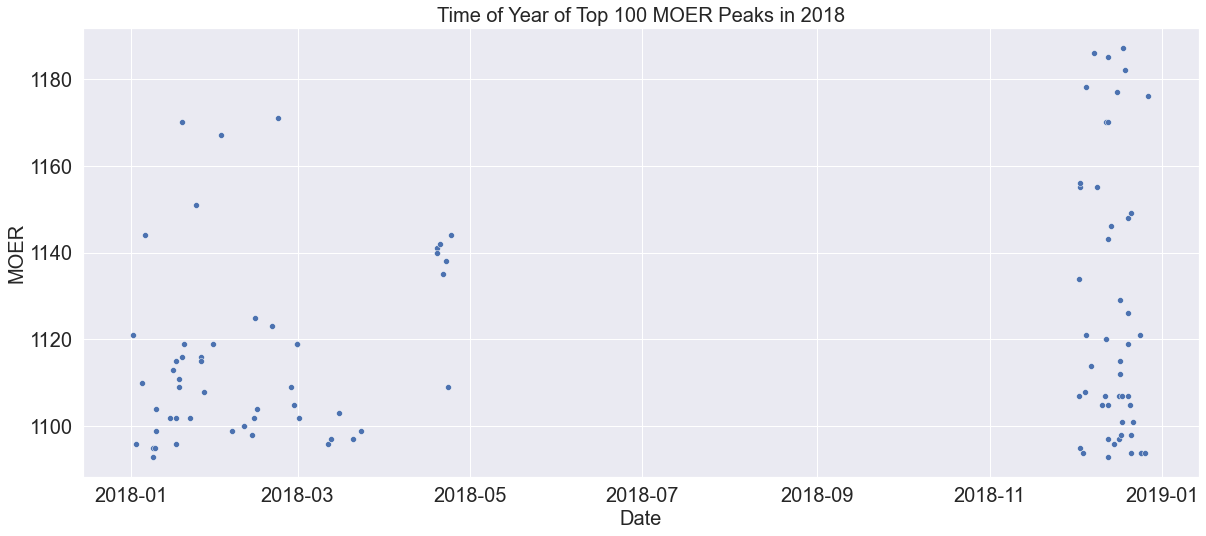

In [735]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.scatterplot(data=top_100_MOER_peaks, x="date", y="MOER")
plt.xticks(fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("MOER", fontsize=20)
plt.title("Time of Year of Top 100 MOER Peaks in 2018", fontsize=20);

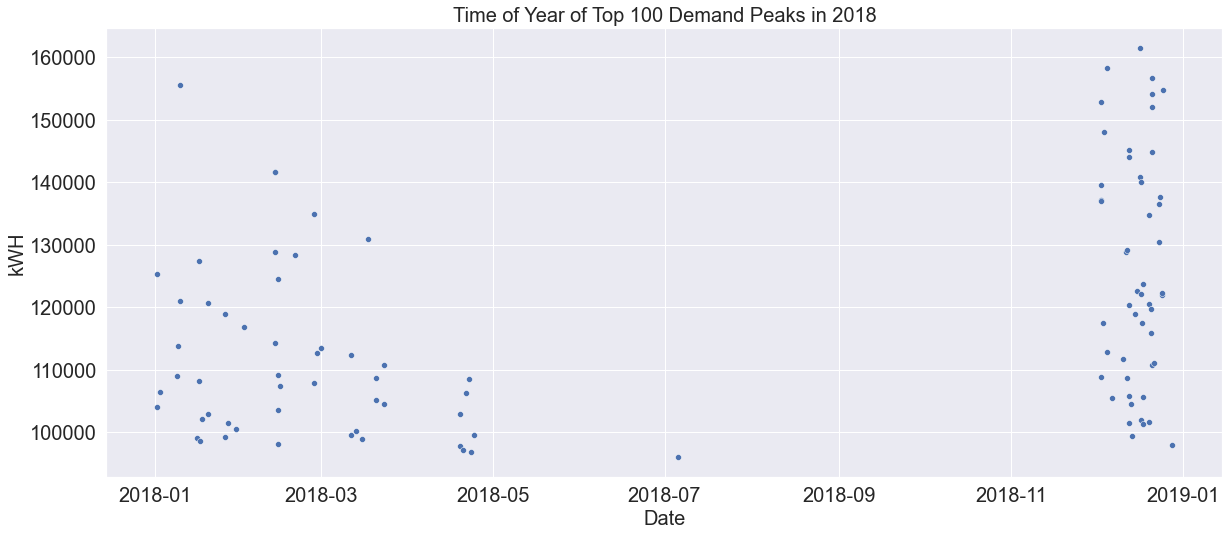

In [736]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.scatterplot(data=top_100_demand_peaks, x="date", y="total")
plt.xticks(fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("kWH", fontsize=20)
plt.title("Time of Year of Top 100 Demand Peaks in 2018", fontsize=20);

# In this section I work with unpaired peaks

In [807]:
top_100_MOER_peak_dates = top_100_MOER_peaks.sort_values(by="date")["date"]
top_100_MOER_peak_dates = pd.DataFrame({"Date" : top_100_MOER_peak_dates})
top_100_MOER_peak_dates["Day"] = [d.date() for d in top_100_MOER_peak_dates["Date"]]
top_100_MOER_peak_dates = top_100_MOER_peak_dates.groupby("Day").agg(lambda x : x)
top_100_MOER_peak_dates

,Date
Day,
2018-01-01,2018-01-01 22:00:00-08:00
2018-01-04,2018-01-04 23:45:00-08:00
2018-01-05,2018-01-05 23:30:00-08:00
2018-01-15,2018-01-15 23:00:00-08:00
2018-01-16,2018-01-16 23:45:00-08:00
...,...
2018-12-26,2018-12-26 23:30:00-08:00
2018-12-27,2018-12-27 03:15:00-08:00
2018-12-28,2018-12-28 04:30:00-08:00


In [808]:
top_100_demand_peak_dates = top_100_demand_peaks.sort_values(by="date")["date"]
top_100_demand_peak_dates = pd.DataFrame({"Date" : top_100_demand_peak_dates})
top_100_demand_peak_dates["Day"] = [d.date() for d in top_100_demand_peak_dates["Date"]]
top_100_demand_peak_dates = top_100_demand_peak_dates.groupby("Day").agg(lambda x : x)
top_100_demand_peak_dates

,Date
Day,
2018-01-01,"[2018-01-01 22:00:00-08:00, 2018-01-01 22:45:0..."
2018-01-02,2018-01-02 23:00:00-08:00
2018-01-08,2018-01-08 22:30:00-08:00
2018-01-09,"[2018-01-09 10:30:00-08:00, 2018-01-09 21:00:0..."
2018-01-15,2018-01-15 23:00:00-08:00
2018-01-16,"[2018-01-16 22:15:00-08:00, 2018-01-16 22:45:0..."
2018-01-17,2018-01-17 23:00:00-08:00
2018-01-19,2018-01-19 23:00:00-08:00
2018-01-25,"[2018-01-25 23:00:00-08:00, 2018-01-25 23:30:0..."


In [809]:
peaks_aggregated = pd.merge(top_100_MOER_peak_dates, top_100_demand_peak_dates, left_index=True, right_index=True, how="outer")
peaks_aggregated = peaks_aggregated.rename(columns={"Date_x" : "MOER Peak", "Date_y" : "Demand Peak"})
peaks_aggregated

,MOER Peak,Demand Peak
Day,,
2018-01-01,2018-01-01 22:00:00-08:00,"[2018-01-01 22:00:00-08:00, 2018-01-01 22:45:0..."
2018-01-02,NaN,2018-01-02 23:00:00-08:00
2018-01-04,2018-01-04 23:45:00-08:00,NaN
2018-01-05,2018-01-05 23:30:00-08:00,NaN
2018-01-08,NaN,2018-01-08 22:30:00-08:00
...,...,...
2018-12-26,2018-12-26 23:30:00-08:00,NaN
2018-12-27,2018-12-27 03:15:00-08:00,2018-12-27 22:45:00-08:00
2018-12-28,2018-12-28 04:30:00-08:00,NaN


In [810]:
for i in range(66):
    print("-------------")
    print(f"Day: {peaks_aggregated.index[i]}")
    print(f"MOER Peak(s): {peaks_aggregated['MOER Peak'][i]}")
    print(f"Demand Peak(s): {peaks_aggregated['Demand Peak'][i]}")

-------------
Day: 2018-01-01
MOER Peak(s): 2018-01-01 22:00:00-08:00
Demand Peak(s): <DatetimeArray>
['2018-01-01 22:00:00-08:00', '2018-01-01 22:45:00-08:00']
Length: 2, dtype: datetime64[ns, America/Los_Angeles]
-------------
Day: 2018-01-02
MOER Peak(s): nan
Demand Peak(s): 2018-01-02 23:00:00-08:00
-------------
Day: 2018-01-04
MOER Peak(s): 2018-01-04 23:45:00-08:00
Demand Peak(s): nan
-------------
Day: 2018-01-05
MOER Peak(s): 2018-01-05 23:30:00-08:00
Demand Peak(s): nan
-------------
Day: 2018-01-08
MOER Peak(s): nan
Demand Peak(s): 2018-01-08 22:30:00-08:00
-------------
Day: 2018-01-09
MOER Peak(s): nan
Demand Peak(s): <DatetimeArray>
['2018-01-09 10:30:00-08:00', '2018-01-09 21:00:00-08:00']
Length: 2, dtype: datetime64[ns, America/Los_Angeles]
-------------
Day: 2018-01-15
MOER Peak(s): 2018-01-15 23:00:00-08:00
Demand Peak(s): 2018-01-15 23:00:00-08:00
-------------
Day: 2018-01-16
MOER Peak(s): 2018-01-16 23:45:00-08:00
Demand Peak(s): <DatetimeArray>
['2018-01-16 22:15

In [847]:
top_100_MOER_peaks = get_top_n_peaks(100, waking_hours_only=True, value = "MOER").sort_values("date")
top_100_demand_peak_dates = top_100_demand_peaks.sort_values(by="date")["date"]

In [848]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

top_MOER_peaks = get_top_n_peaks(100, waking_hours_only=True, value = "MOER").reset_index()

distance = pd.DataFrame({"MOER Peak" : top_MOER_peaks.sort_values(by="date")["date"]})
distance = distance.reset_index()
top_demand_peaks = get_top_n_peaks(100, waking_hours_only=True, value = "total").reset_index()
timestamps = []
for i in range(100):
    timestamps.append(nearest(top_demand_peaks["date"], distance["MOER Peak"][i]))
    
distance["Closest Demand Peak"] = timestamps

In [849]:
distance["difference"] = [td.days * 24 * 60 + (td.seconds / 60) for td in (distance["MOER Peak"] - distance["Closest Demand Peak"])]

In [850]:
sum(distance["difference"] == 0)

68

In [851]:
distance["difference"].describe()

count     100.000000
mean       -5.700000
std      1136.609352
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64

In [852]:
distance

,index,MOER Peak,Closest Demand Peak,difference
0,33,2018-01-01 22:00:00-08:00,2018-01-01 22:00:00-08:00,0.0
1,86,2018-01-02 23:00:00-08:00,2018-01-02 23:00:00-08:00,0.0
2,50,2018-01-04 23:45:00-08:00,2018-01-02 23:00:00-08:00,2925.0
3,19,2018-01-05 23:30:00-08:00,2018-01-08 22:30:00-08:00,-4260.0
4,99,2018-01-08 22:30:00-08:00,2018-01-08 22:30:00-08:00,0.0
...,...,...,...,...
95,32,2018-12-23 23:45:00-08:00,2018-12-23 17:30:00-08:00,375.0
96,96,2018-12-24 09:00:00-08:00,2018-12-24 09:00:00-08:00,0.0
97,95,2018-12-24 09:30:00-08:00,2018-12-24 09:30:00-08:00,0.0
98,93,2018-12-25 23:30:00-08:00,2018-12-24 19:15:00-08:00,1695.0


<AxesSubplot:xlabel='difference'>

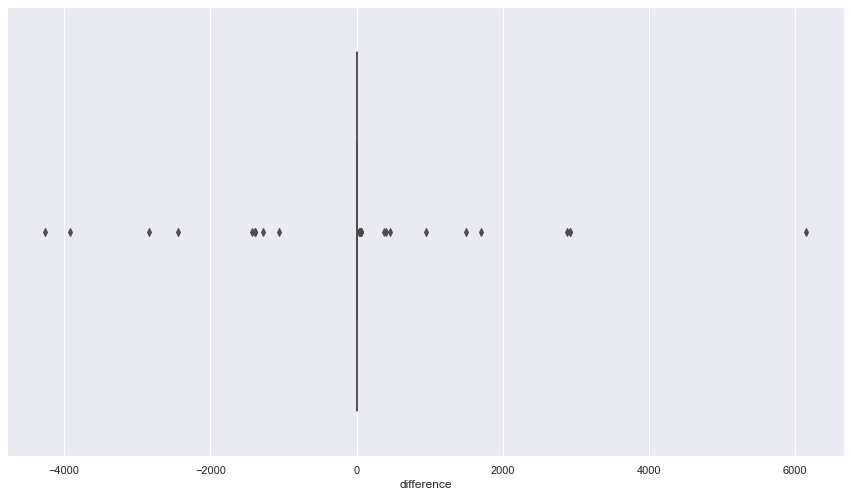

In [853]:
sns.boxplot(distance["difference"])

In [854]:
distance["difference"].describe()

count     100.000000
mean       -5.700000
std      1136.609352
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64

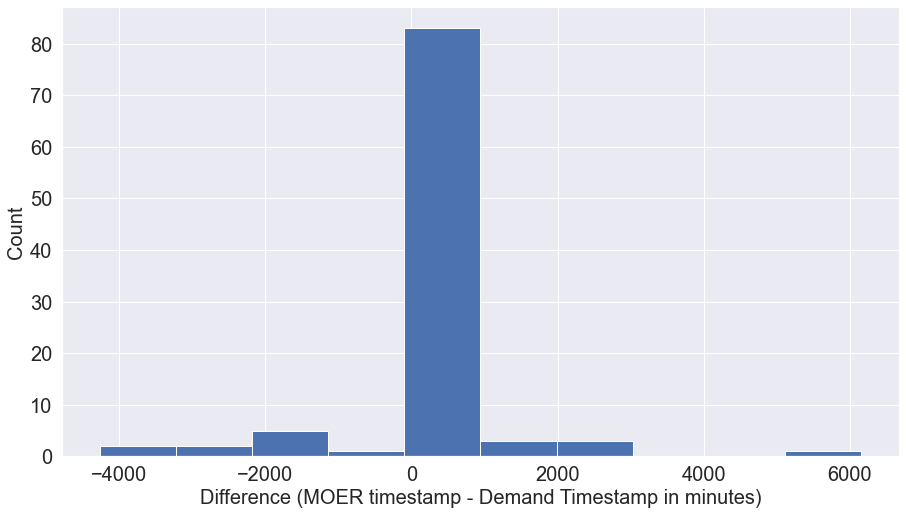

In [855]:
sns.set(rc={'figure.figsize':(15,8.27)})
(a, bins, c) = plt.hist(distance["difference"])
plt.xlabel("Difference (MOER timestamp - Demand Timestamp in minutes)", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("peak-concurrence-histogram-waking-only.png", edgecolor='black', dpi=400, transparent=True);

In [856]:
bins

array([-4260., -3219., -2178., -1137.,   -96.,   945.,  1986.,  3027.,
        4068.,  5109.,  6150.])

In [857]:
distance

,index,MOER Peak,Closest Demand Peak,difference
0,33,2018-01-01 22:00:00-08:00,2018-01-01 22:00:00-08:00,0.0
1,86,2018-01-02 23:00:00-08:00,2018-01-02 23:00:00-08:00,0.0
2,50,2018-01-04 23:45:00-08:00,2018-01-02 23:00:00-08:00,2925.0
3,19,2018-01-05 23:30:00-08:00,2018-01-08 22:30:00-08:00,-4260.0
4,99,2018-01-08 22:30:00-08:00,2018-01-08 22:30:00-08:00,0.0
...,...,...,...,...
95,32,2018-12-23 23:45:00-08:00,2018-12-23 17:30:00-08:00,375.0
96,96,2018-12-24 09:00:00-08:00,2018-12-24 09:00:00-08:00,0.0
97,95,2018-12-24 09:30:00-08:00,2018-12-24 09:30:00-08:00,0.0
98,93,2018-12-25 23:30:00-08:00,2018-12-24 19:15:00-08:00,1695.0


In [858]:
top_100_MOER_peaks = get_top_n_peaks(100, waking_hours_only=False).sort_values("date")

In [859]:
top_100_demand_peaks = get_top_n_peaks(100, waking_hours_only=False, value = "total").sort_values("date")

In [860]:
distance = pd.DataFrame({"MOER Peak" : top_100_MOER_peaks.sort_values(by="date")["date"]})
distance = distance.reset_index()
timestamps = []
for i in range(100):
    timestamps.append(nearest(top_100_demand_peaks["date"], distance["MOER Peak"][i]))
    
distance["Closest Demand Peak"] = timestamps
distance["difference"] = [td.days * 24 * 60 + (td.seconds / 60) for td in (distance["MOER Peak"] - distance["Closest Demand Peak"])]

In [870]:
sum(distance["difference"] == 0)

47

In [861]:
distance["difference"].describe()

count     100.000000
mean     -106.500000
std      1554.068707
min     -6570.000000
25%         0.000000
50%         0.000000
75%        45.000000
max      6390.000000
Name: difference, dtype: float64

<AxesSubplot:xlabel='difference'>

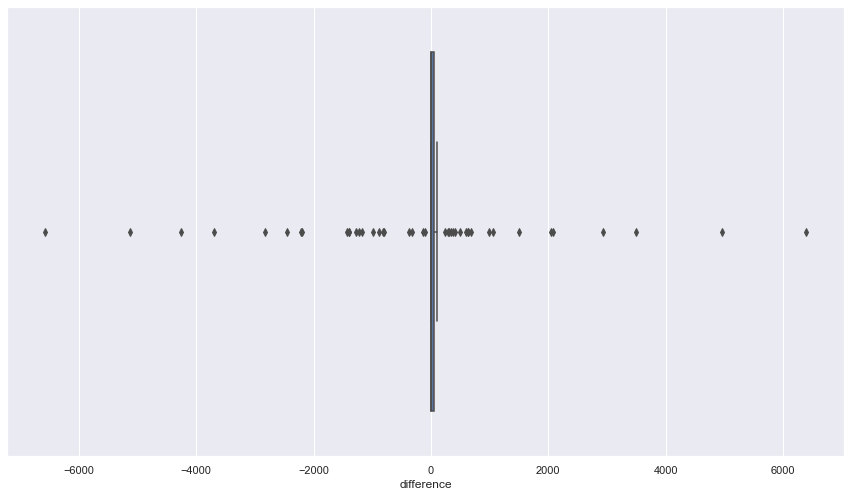

In [862]:
sns.boxplot(distance["difference"])

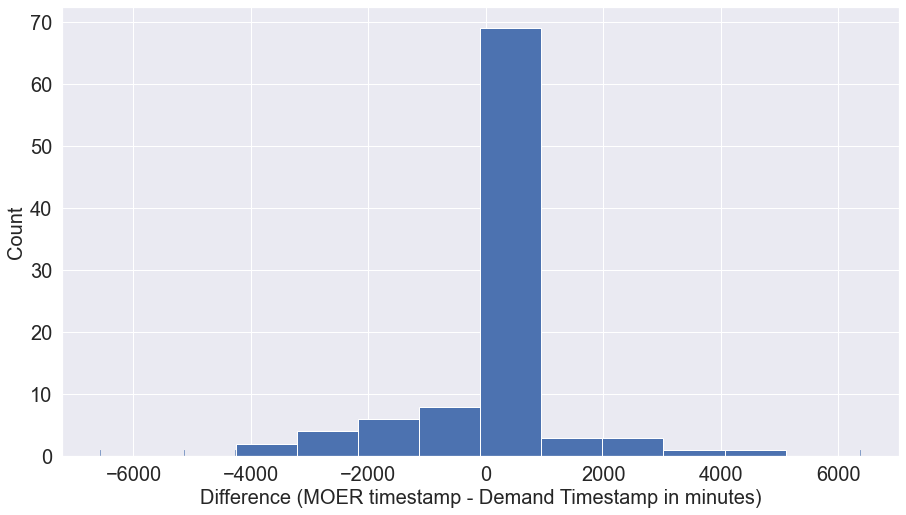

In [865]:
sns.histplot(distance["difference"])
plt.hist(distance["difference"], bins=bins)
plt.xlabel("Difference (MOER timestamp - Demand Timestamp in minutes)", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("peak-concurrence-histogram-all-hours.png", edgecolor='black', dpi=400, transparent=True);

# Now, examining peak concurrence between MOER and each peak subcategory

In [885]:
plt.close()

---------------
Comparing MOER peaks and ceiling_fan peaks
count      100.000000
mean      3534.300000
std      12856.662896
min      -3915.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      54015.000000
Name: difference, dtype: float64
Number of concurrent peaks: 73


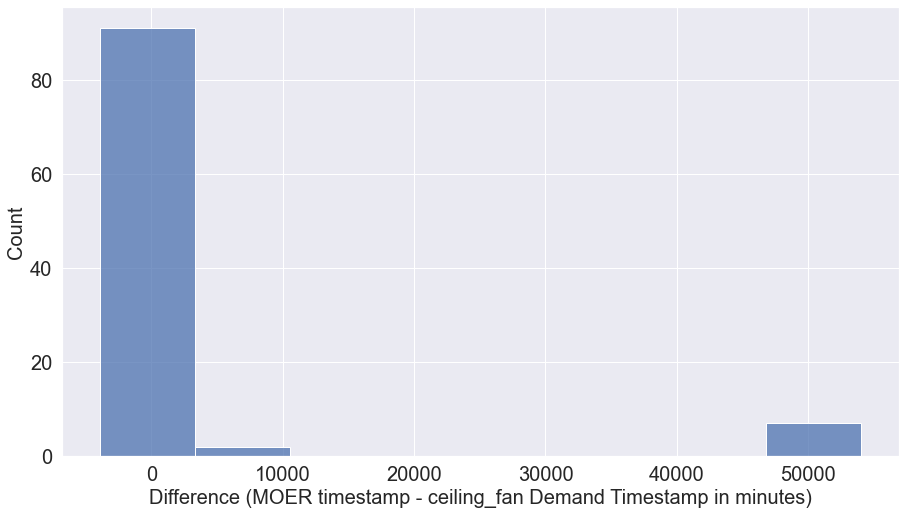

---------------
Comparing MOER peaks and clothes_dryer peaks
count     100.000000
mean      112.800000
std      1134.677527
min     -3915.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 69


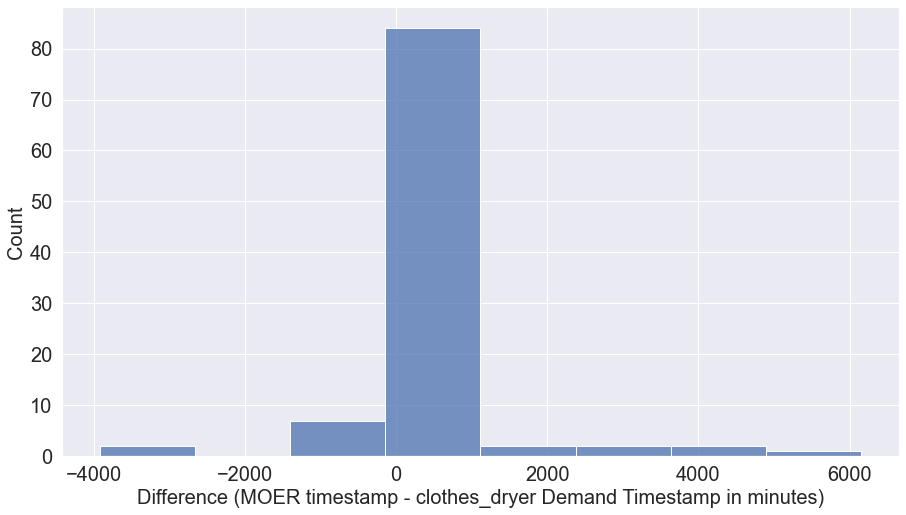

---------------
Comparing MOER peaks and clothes_washer peaks
count     100.000000
mean     -114.150000
std      1512.575911
min     -6750.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      7605.000000
Name: difference, dtype: float64
Number of concurrent peaks: 66


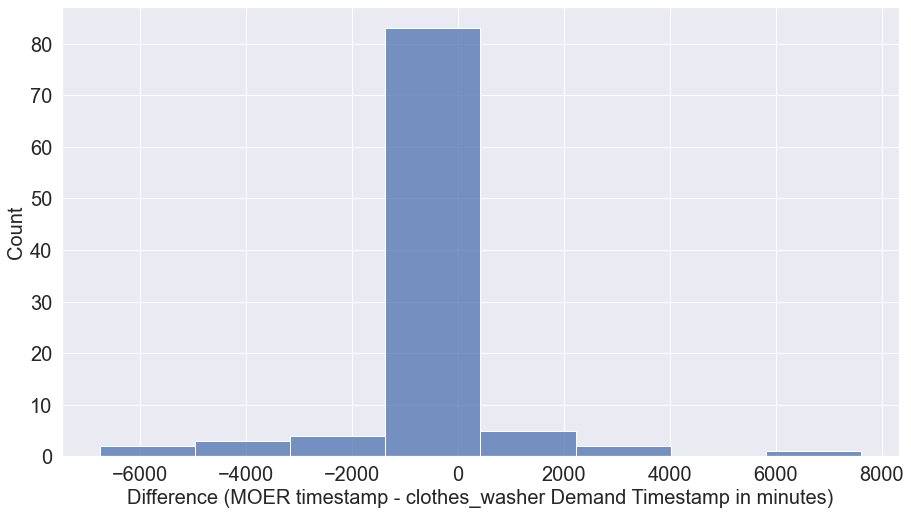

---------------
Comparing MOER peaks and cooling_fans_pumps peaks
count     100.000000
mean       50.100000
std      1866.938695
min     -8595.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      7605.000000
Name: difference, dtype: float64
Number of concurrent peaks: 69


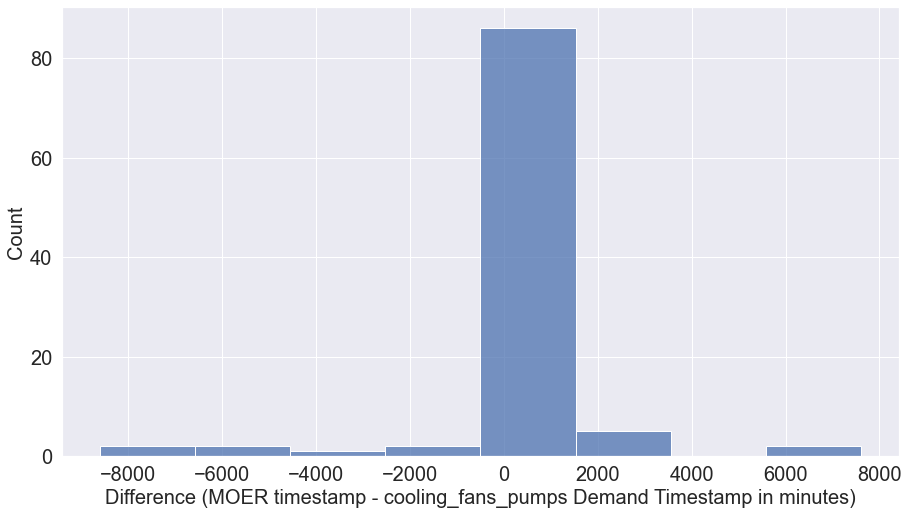

---------------
Comparing MOER peaks and cooling peaks
count     100.000000
mean      118.050000
std      1050.120458
min     -4425.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3990.000000
Name: difference, dtype: float64
Number of concurrent peaks: 68


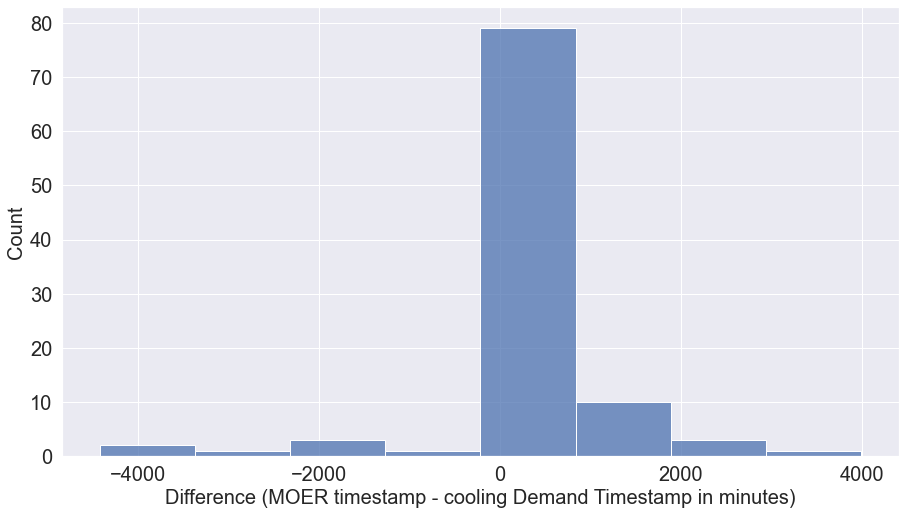

---------------
Comparing MOER peaks and dishwasher peaks
count     100.000000
mean      -54.150000
std      1761.943523
min     -6750.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      7605.000000
Name: difference, dtype: float64
Number of concurrent peaks: 69


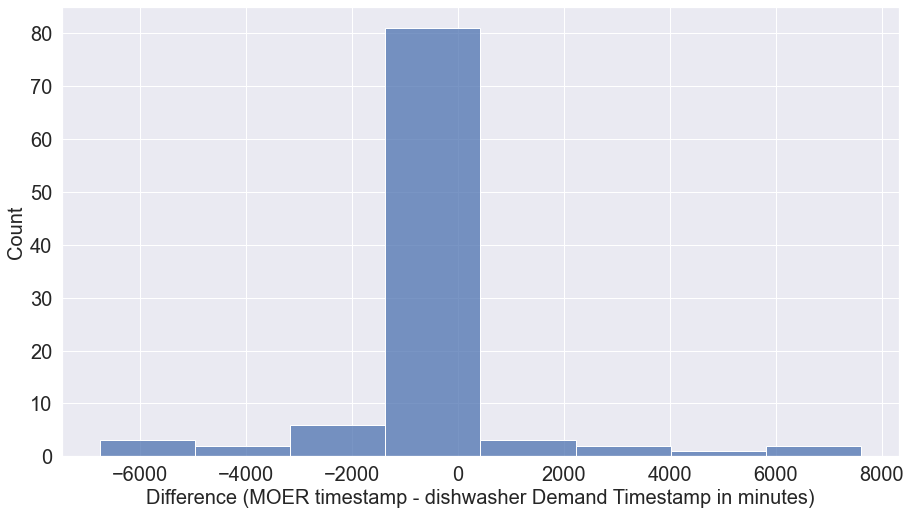

---------------
Comparing MOER peaks and freezer peaks
count     100.000000
mean       17.850000
std      1061.908006
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 68


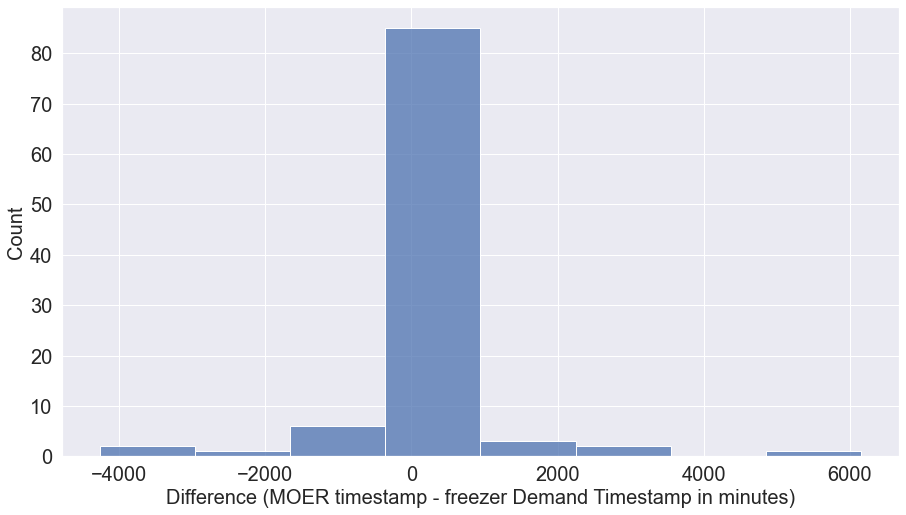

---------------
Comparing MOER peaks and heating_fans_pumps peaks
count      100.000000
mean       179.850000
std       1799.873095
min      -5745.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      10110.000000
Name: difference, dtype: float64
Number of concurrent peaks: 79


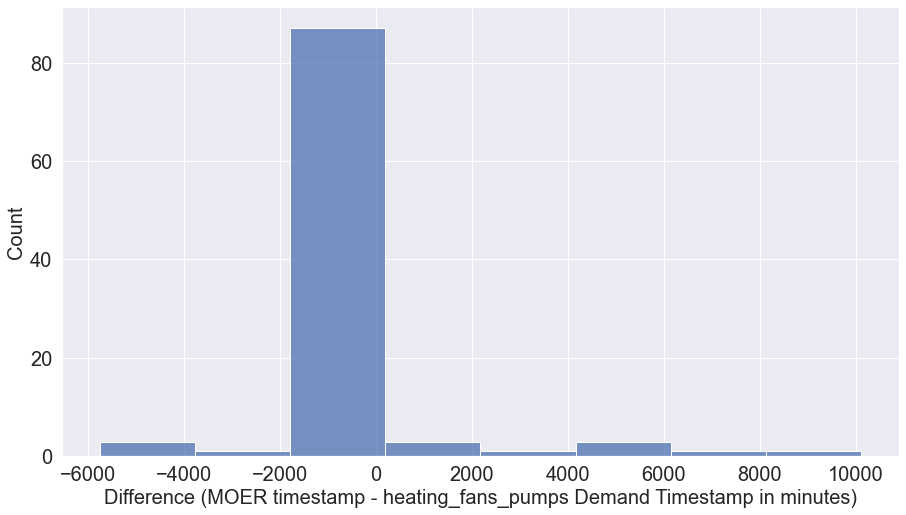

---------------
Comparing MOER peaks and heating_hp_bkup peaks
count      100.000000
mean      1746.000000
std      12149.233421
min     -54825.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      51720.000000
Name: difference, dtype: float64
Number of concurrent peaks: 74


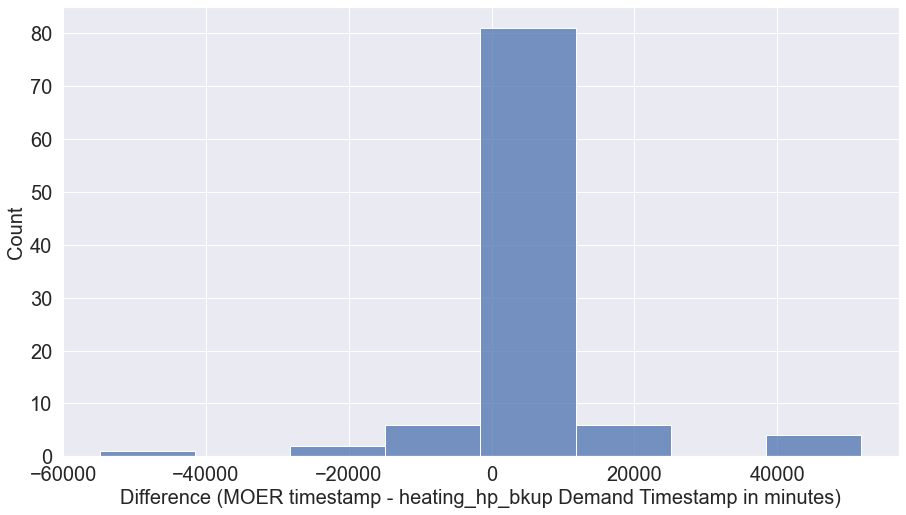

---------------
Comparing MOER peaks and heating peaks
count     100.00000
mean       14.10000
std      1750.80218
min     -9885.00000
25%         0.00000
50%         0.00000
75%         0.00000
max      7215.00000
Name: difference, dtype: float64
Number of concurrent peaks: 79


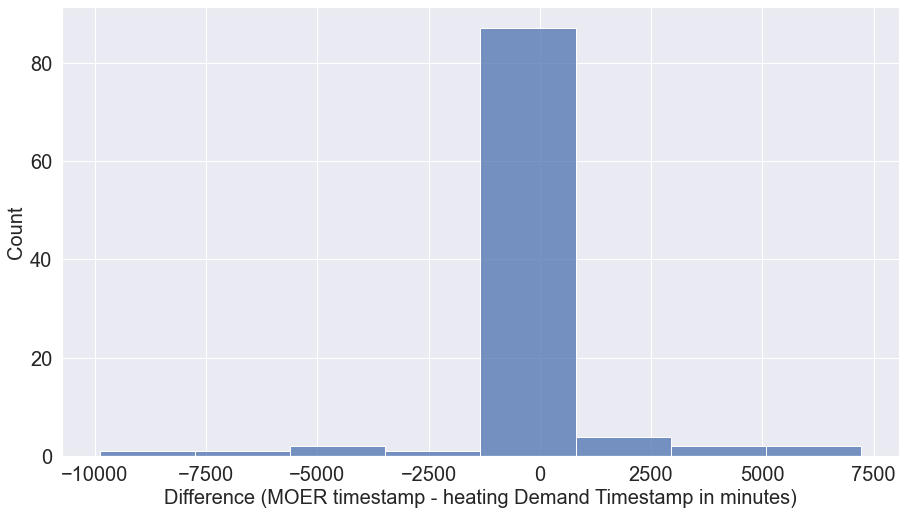

---------------
Comparing MOER peaks and hot_tub_heater peaks
count     100.000000
mean      -29.850000
std      1475.110928
min     -6750.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      7605.000000
Name: difference, dtype: float64
Number of concurrent peaks: 70


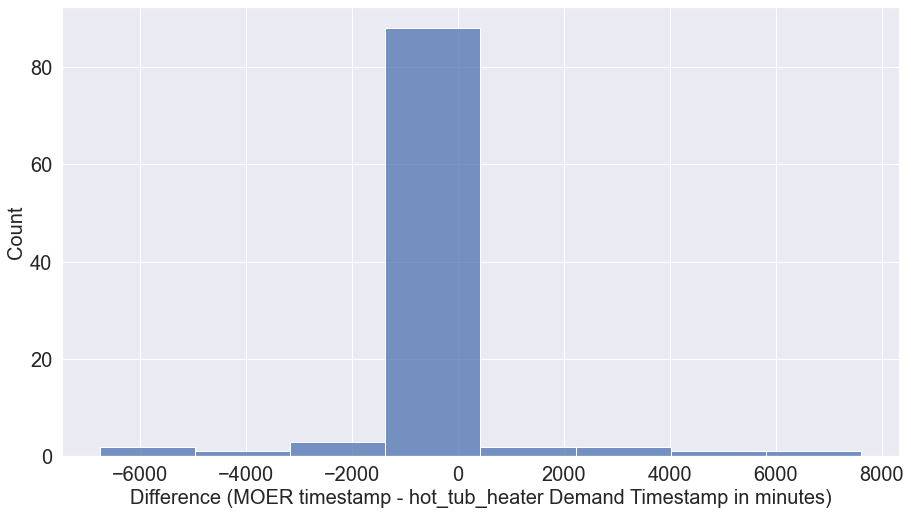

---------------
Comparing MOER peaks and hot_tub_pump peaks
count      100.00000
mean      3194.70000
std      11844.47128
min      -5610.00000
25%          0.00000
50%          0.00000
75%          0.00000
max      50025.00000
Name: difference, dtype: float64
Number of concurrent peaks: 68


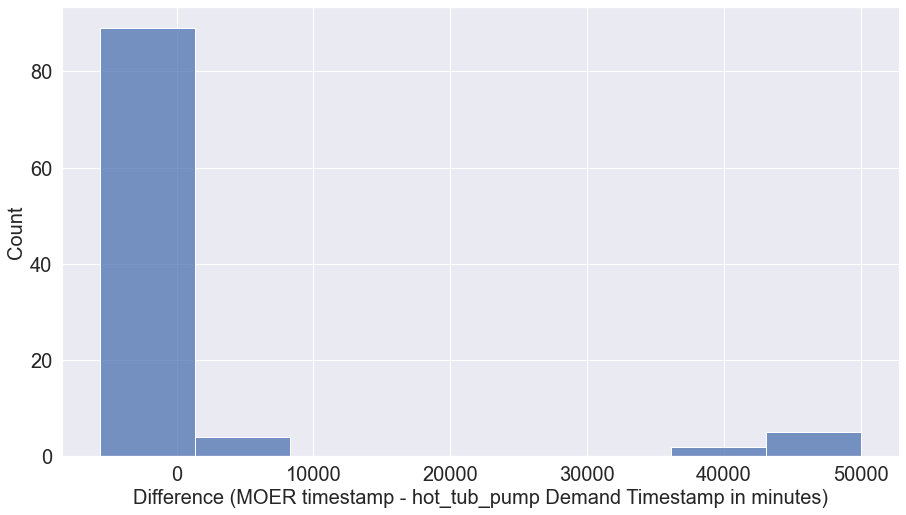

---------------
Comparing MOER peaks and hot_water peaks
count     100.000000
mean       77.850000
std      1010.096069
min     -3915.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 70


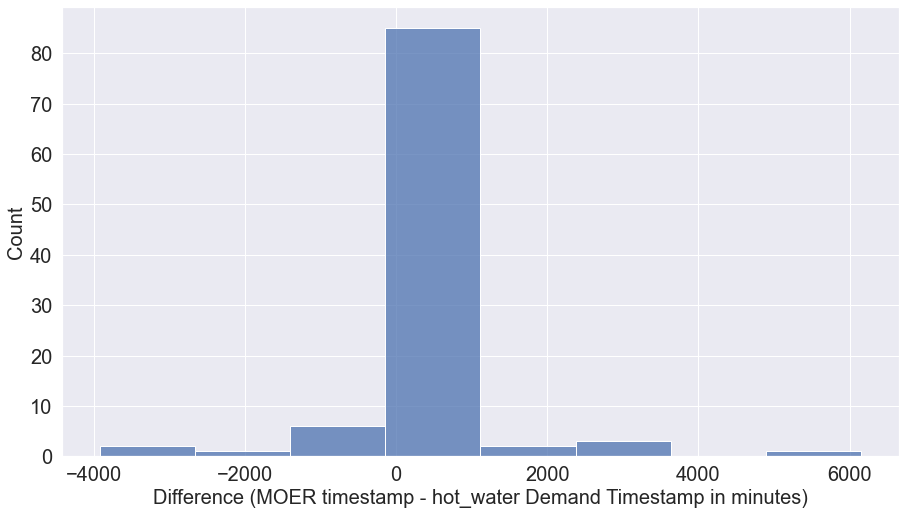

---------------
Comparing MOER peaks and lighting_exterior peaks
count      100.000000
mean      3443.850000
std      12431.579307
min      -3240.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      52470.000000
Name: difference, dtype: float64
Number of concurrent peaks: 78


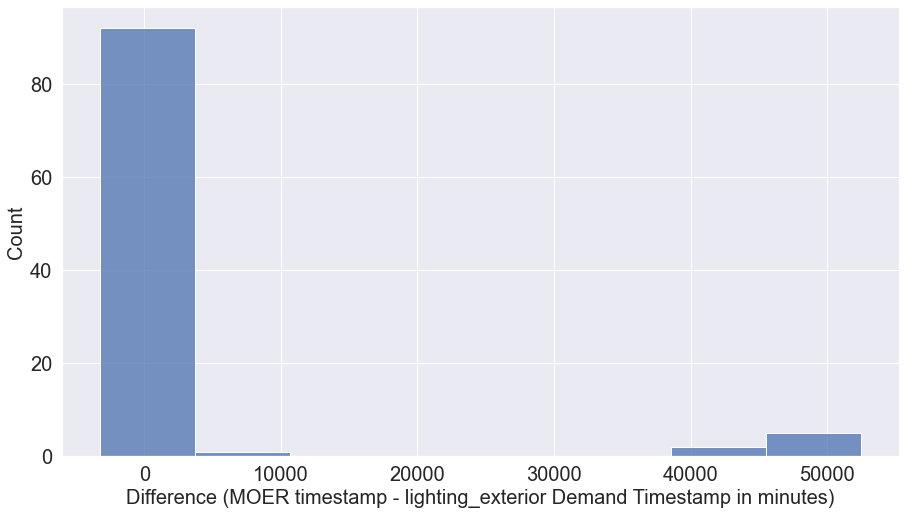

---------------
Comparing MOER peaks and lighting_garage peaks
count      100.000000
mean      3597.900000
std      12825.201402
min      -3240.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      54015.000000
Name: difference, dtype: float64
Number of concurrent peaks: 79


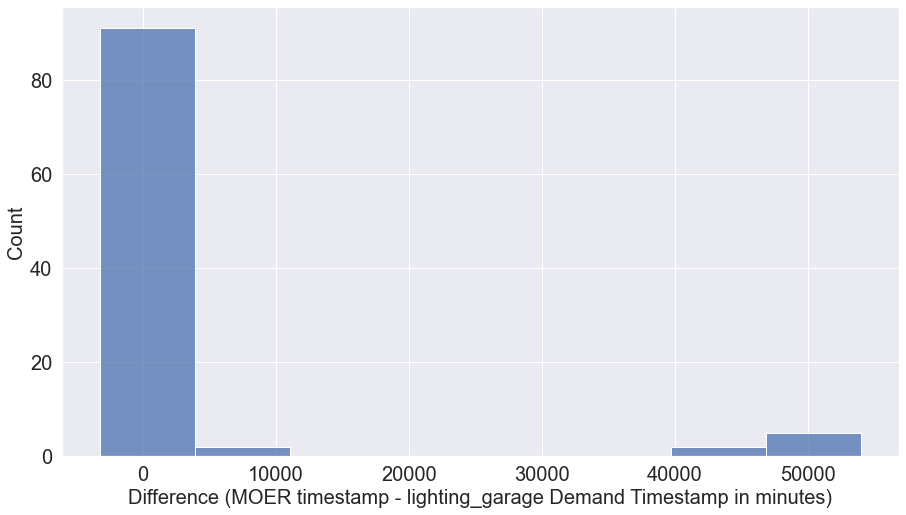

---------------
Comparing MOER peaks and lighting_interior peaks
count     100.000000
mean       10.950000
std      1138.136146
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 68


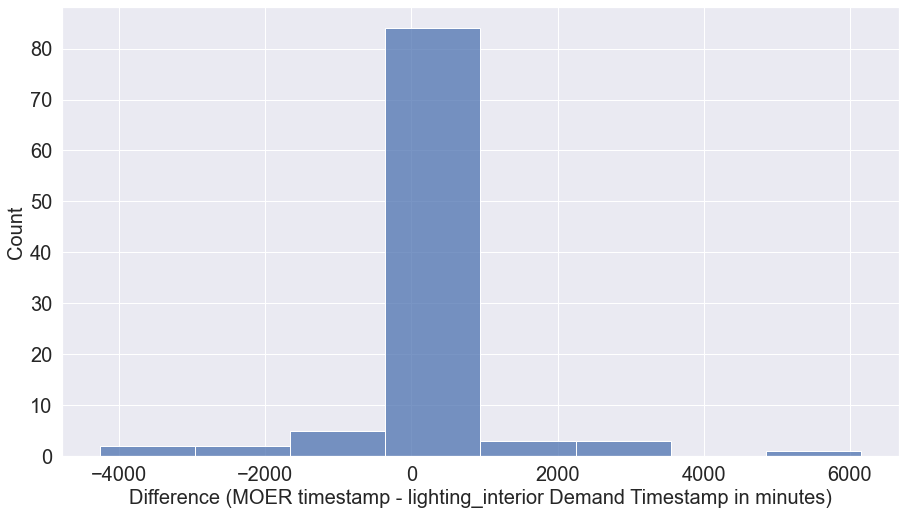

---------------
Comparing MOER peaks and mech_vent peaks
count     100.000000
mean       55.500000
std      1124.783818
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      5745.000000
Name: difference, dtype: float64
Number of concurrent peaks: 70


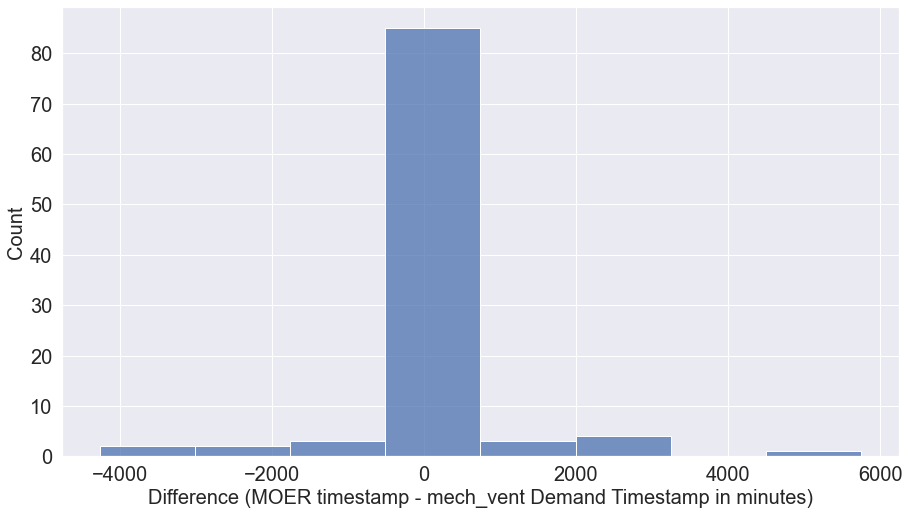

---------------
Comparing MOER peaks and plug_loads peaks
count     100.000000
mean       -0.150000
std      1143.202231
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 68


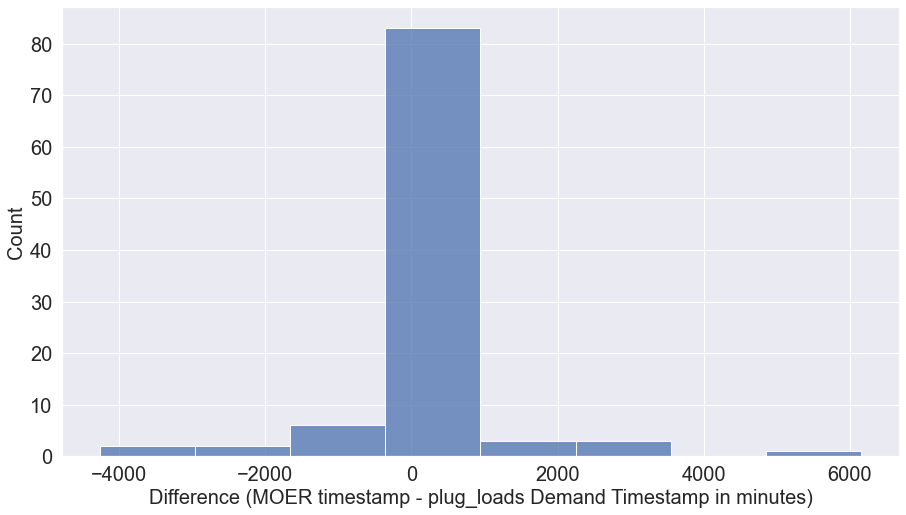

---------------
Comparing MOER peaks and pool_heater peaks
count     100.000000
mean      -78.150000
std      1037.438487
min     -3915.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 71


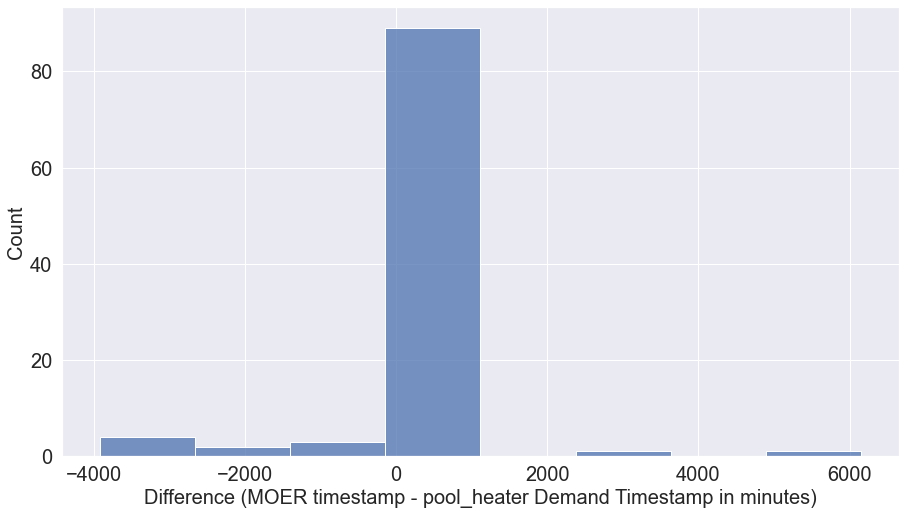

---------------
Comparing MOER peaks and pool_pump peaks
count     100.000000
mean       -9.450000
std       623.307363
min     -3900.000000
25%         0.000000
50%         0.000000
75%         7.500000
max      3045.000000
Name: difference, dtype: float64
Number of concurrent peaks: 70


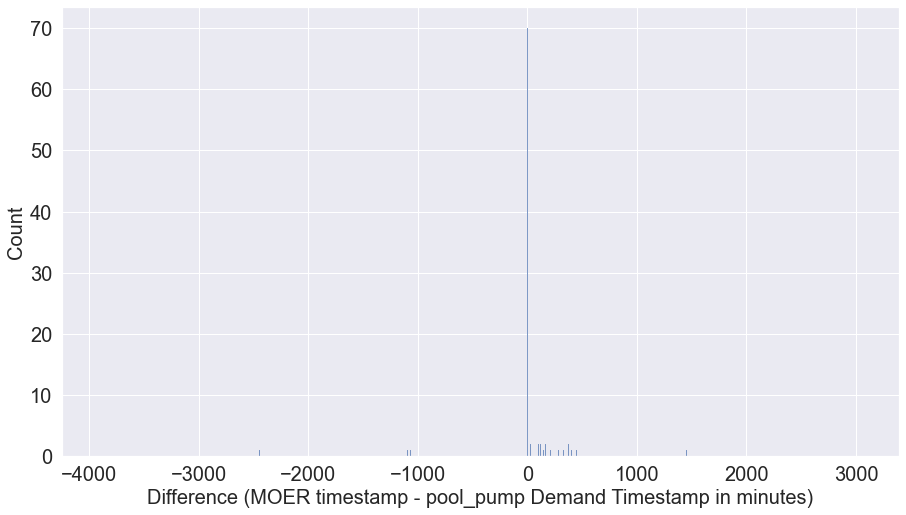

---------------
Comparing MOER peaks and range_oven peaks
count     100.000000
mean      121.350000
std      1222.482748
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 68


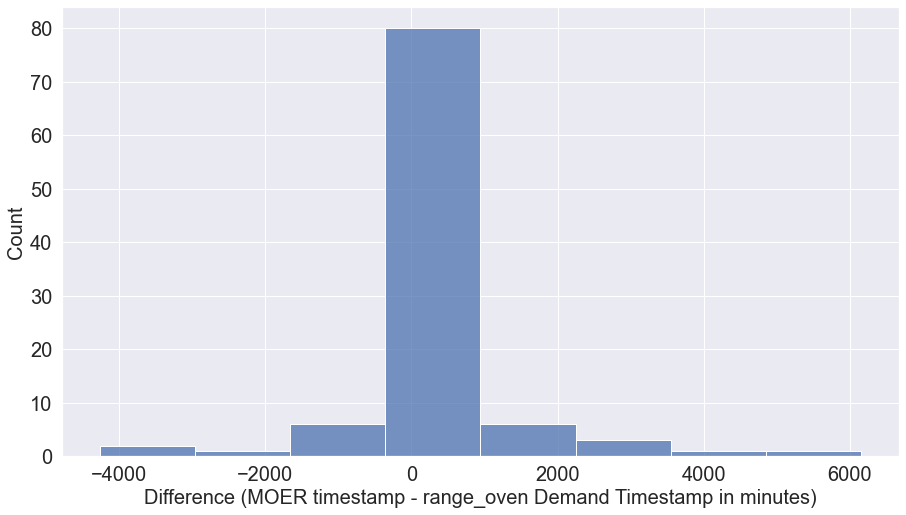

---------------
Comparing MOER peaks and refrigerator peaks
count     100.000000
mean       -7.350000
std      1030.548166
min     -3915.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 68


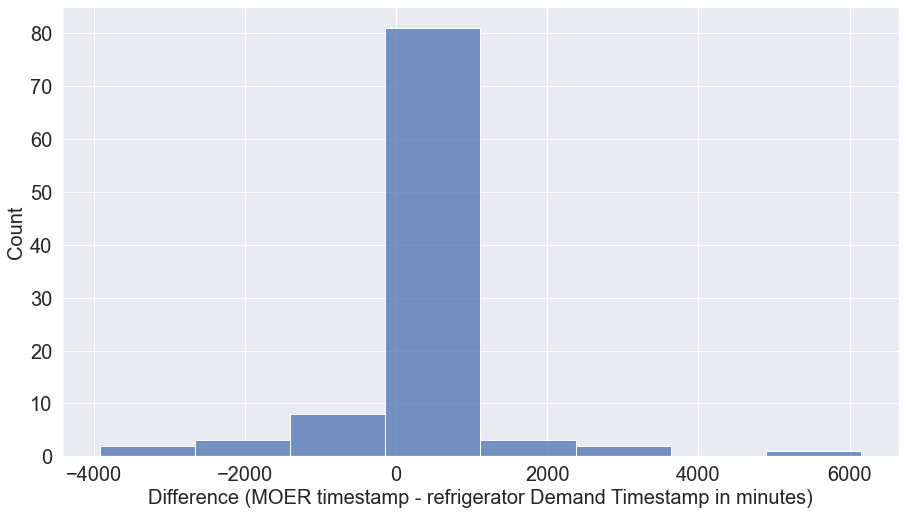

---------------
Comparing MOER peaks and well_pump peaks
count      100.000000
mean      3443.850000
std      12431.579307
min      -3240.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      52470.000000
Name: difference, dtype: float64
Number of concurrent peaks: 78


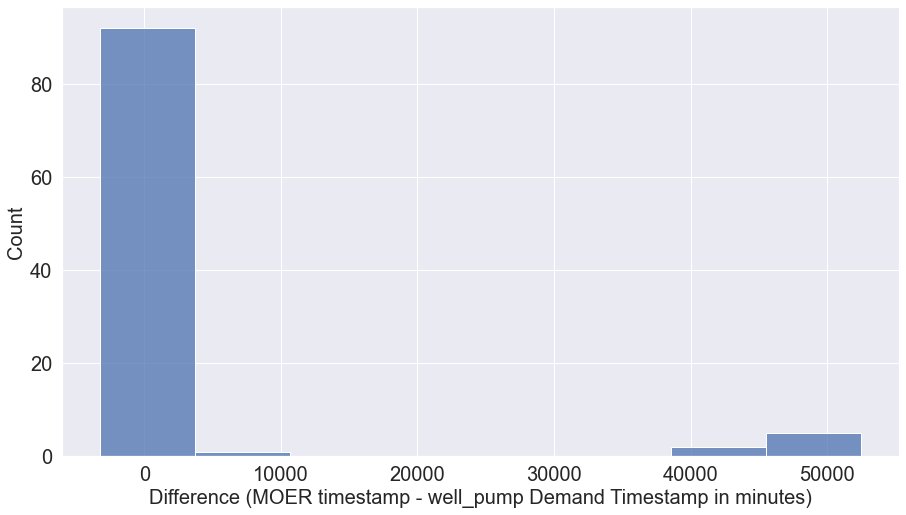

---------------
Comparing MOER peaks and total peaks
count     100.000000
mean       -5.700000
std      1136.609352
min     -4260.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      6150.000000
Name: difference, dtype: float64
Number of concurrent peaks: 68


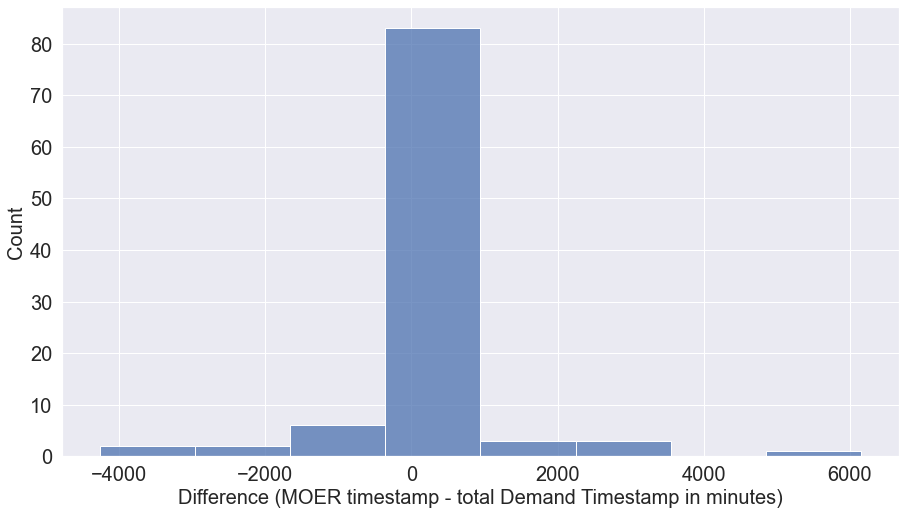

In [888]:
top_100_MOER_peaks = get_top_n_peaks(100, waking_hours_only=True)

for cat in categories:
    top_100_demand_peaks_categorical = get_top_n_peaks(100, waking_hours_only=True, value=cat).sort_values("date")
    
    distance = pd.DataFrame({"MOER Peak" : top_100_MOER_peaks.sort_values(by="date")["date"]})
    distance = distance.reset_index()
    timestamps = []
    for i in range(100):
        timestamps.append(nearest(top_100_demand_peaks_categorical["date"], distance["MOER Peak"][i]))
    
    distance["Closest Demand Peak"] = timestamps
    distance["difference"] = [td.days * 24 * 60 + (td.seconds / 60) for td in (distance["MOER Peak"] - distance["Closest Demand Peak"])]
    
    print("---------------")
    print(f"Comparing MOER peaks and {cat} peaks")
    print(distance["difference"].describe())
    num_concurrent_peaks = sum(distance["difference"] == 0)
    print(f"Number of concurrent peaks: {num_concurrent_peaks}")
    
    sns.histplot(distance["difference"])
    plt.xlabel(f"Difference (MOER timestamp - {cat} Demand Timestamp in minutes)", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    filename = "peak-concurrence-histogram-" + cat + "-waking-only.png"
    plt.savefig(filename, edgecolor='black', dpi=400, transparent=True)
    plt.close()

---------------
Comparing MOER peaks and pool_pump peaks
count     100.000000
mean       -9.450000
std       623.307363
min     -3900.000000
25%         0.000000
50%         0.000000
75%         7.500000
max      3045.000000
Name: difference, dtype: float64
Number of concurrent peaks: 70


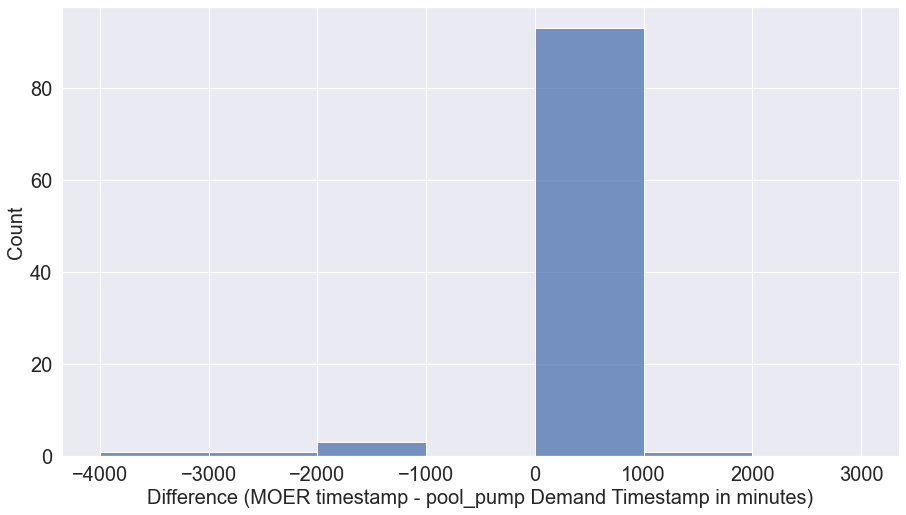

In [890]:
    cat = "pool_pump"
    top_100_demand_peaks_categorical = get_top_n_peaks(100, waking_hours_only=True, value=cat).sort_values("date")
    
    distance = pd.DataFrame({"MOER Peak" : top_100_MOER_peaks.sort_values(by="date")["date"]})
    distance = distance.reset_index()
    timestamps = []
    for i in range(100):
        timestamps.append(nearest(top_100_demand_peaks_categorical["date"], distance["MOER Peak"][i]))
    
    distance["Closest Demand Peak"] = timestamps
    distance["difference"] = [td.days * 24 * 60 + (td.seconds / 60) for td in (distance["MOER Peak"] - distance["Closest Demand Peak"])]
    
    print("---------------")
    print(f"Comparing MOER peaks and {cat} peaks")
    print(distance["difference"].describe())
    num_concurrent_peaks = sum(distance["difference"] == 0)
    print(f"Number of concurrent peaks: {num_concurrent_peaks}")
    
    sns.histplot(distance["difference"], bins=np.arange(-4000, 4000, 1000))
    plt.xlabel(f"Difference (MOER timestamp - {cat} Demand Timestamp in minutes)", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(f"peak-concurrence-histogram-{cat}-waking-only", edgecolor='black', dpi=400, transparent=True)